In [1]:
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statsmodels.api as sm

## Time Series Mini Project

### Acquire

In [2]:
## <-- getting our dataframe

df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [3]:
df.head() ## <-- looking at our dataframe

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [4]:
df.info() ## <-- looking at our column values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [5]:
df.dt ## <-- seeing if we have a datetime object we do not

0         1743-11-01
1         1743-12-01
2         1744-01-01
3         1744-02-01
4         1744-03-01
             ...    
577457    2013-05-01
577458    2013-06-01
577459    2013-07-01
577460    2013-08-01
577461    2013-09-01
Name: dt, Length: 577462, dtype: object

In [6]:
df.dt = pd.to_datetime(df.dt, format = '%Y-%m-%d') ## converting to date time

In [7]:
df.dt ## <-- quality assurance check

0        1743-11-01
1        1743-12-01
2        1744-01-01
3        1744-02-01
4        1744-03-01
            ...    
577457   2013-05-01
577458   2013-06-01
577459   2013-07-01
577460   2013-08-01
577461   2013-09-01
Name: dt, Length: 577462, dtype: datetime64[ns]

In [8]:
df.Country.value_counts() ## <-- determining what location to pick

## I want to pick one with the most values

Switzerland                            3239
Austria                                3239
Finland                                3239
Czech Republic                         3239
Ukraine                                3239
                                       ... 
Guam                                   1329
Northern Mariana Islands               1329
Heard Island And Mcdonald Islands       788
French Southern And Antarctic Lands     788
Antarctica                              764
Name: Country, Length: 243, dtype: int64

In [9]:
df.describe().T ## <-- looking at my numerical statistics

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,544811.0,17.193354,10.953966,-37.658,10.025,20.901,25.814,38.842
AverageTemperatureUncertainty,545550.0,1.019057,1.201930,0.052,0.323,0.571,1.206,15.003


#### Column Distributions

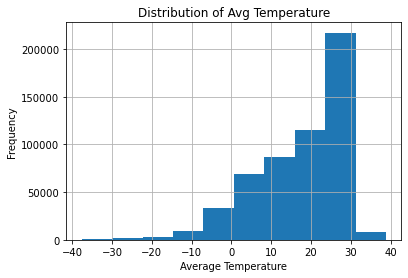

In [10]:
df.AverageTemperature.hist()
plt.title('Distribution of Avg Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.show()

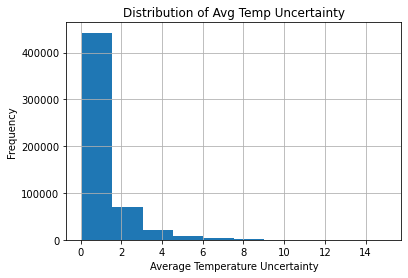

In [11]:
df.AverageTemperatureUncertainty.hist()
plt.title('Distribution of Avg Temp Uncertainty')
plt.xlabel('Average Temperature Uncertainty')
plt.ylabel('Frequency')
plt.show()

### Prepare

In [12]:
df.Country.value_counts() ## <-- Lets pick Netherlands 

## for our location

Switzerland                            3239
Austria                                3239
Finland                                3239
Czech Republic                         3239
Ukraine                                3239
                                       ... 
Guam                                   1329
Northern Mariana Islands               1329
Heard Island And Mcdonald Islands       788
French Southern And Antarctic Lands     788
Antarctica                              764
Name: Country, Length: 243, dtype: int64

In [13]:
df = df[df.Country == "Netherlands (Europe)"] ## <-- narrowing down to the netherlands

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
364075,1743-11-01,7.606,1.746,Netherlands (Europe)
364076,1743-12-01,NaN,NaN,Netherlands (Europe)
364077,1744-01-01,NaN,NaN,Netherlands (Europe)
364078,1744-02-01,NaN,NaN,Netherlands (Europe)
364079,1744-03-01,NaN,NaN,Netherlands (Europe)


In [14]:
df.Country.value_counts() ## <-- quality assurance check

Netherlands (Europe)    3239
Name: Country, dtype: int64

In [15]:
df.shape ## <-- looking at our row shape before we check for nulls

(3239, 4)

In [16]:
df.isnull().sum() ## <-- looking at our null values

dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
Country                           0
dtype: int64

73 null values is not very many compared to the 3239 rows of data in the dataframe. To make this easy I am going to drop the nulls and move forward.

In [17]:
df = df.dropna() ## <-- drop the nulls

df.isnull().sum() ## <-- quality assurance check

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

#### Column Distribution Part II

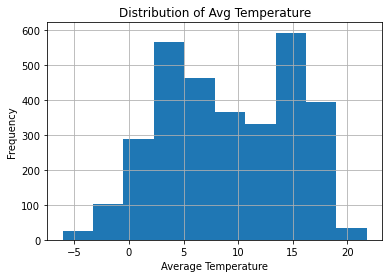

In [18]:
df.AverageTemperature.hist()
plt.title('Distribution of Avg Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.show()

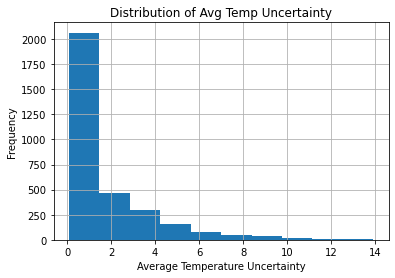

In [19]:
df.AverageTemperatureUncertainty.hist()
plt.title('Distribution of Avg Temp Uncertainty')
plt.xlabel('Average Temperature Uncertainty')
plt.ylabel('Frequency')
plt.show()

After looking in to Average Temperature Uncertainty and its definition. Given the goal of this project is to create a forecast for average temperature in the Netherlands I do not think it will bring and value and we are going to remove it from our dataframe before moving on to explore

In [20]:
df = df.drop(columns = 'AverageTemperatureUncertainty')
df.head()

,dt,AverageTemperature,Country
364075,1743-11-01,7.606,Netherlands (Europe)
364080,1744-04-01,7.986,Netherlands (Europe)
364081,1744-05-01,11.306,Netherlands (Europe)
364082,1744-06-01,14.475,Netherlands (Europe)
364083,1744-07-01,16.013,Netherlands (Europe)


In [21]:
## setting date as index and sorting for vis purposes

df = df.set_index('dt').sort_index() 

In [22]:
df.head() ##

,AverageTemperature,Country
dt,,
1743-11-01,7.606,Netherlands (Europe)
1744-04-01,7.986,Netherlands (Europe)
1744-05-01,11.306,Netherlands (Europe)
1744-06-01,14.475,Netherlands (Europe)
1744-07-01,16.013,Netherlands (Europe)
